In [1]:
!pip install gradio

     |████████████████████████████████| 2.0 MB 5.4 MB/s 
     |████████████████████████████████| 1.9 MB 36.1 MB/s 
     |████████████████████████████████| 206 kB 45.4 MB/s 
     |████████████████████████████████| 961 kB 36.7 MB/s 
     |████████████████████████████████| 3.5 MB 49.3 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=0d5607b7acfcc9fce37151bb28fb34cbb97bedb2bce669ff487e66de2fd9e0dc
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=ba2e04a1be22ba2145445a29bc84c6ff6e3b1bbf409278c16492a5443f91e286
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [2]:
import tensorflow as tf
import gradio as gr
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
import tensorflow_datasets as tfds
import pickle
from PIL import Image, ImageOps

In [4]:
import zipfile
import os
import requests
import itertools

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image

In [6]:
import numpy as np
import datetime

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def load_class():
  with open ('/content/drive/MyDrive/Model/outfile.txt', 'rb') as fp:
      itemlist = pickle.load(fp)
      print(itemlist)
  return itemlist

<HR>

In [9]:

def create_tensorboard_callback(dir_name, experiment_name):
 
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [10]:
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)

True


In [13]:
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True)

In [14]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved


In [15]:
class_names = ds_info.features["label"].names

In [16]:
with open('outfile.txt', 'wb') as fp:
    pickle.dump(class_names, fp)

In [17]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
        


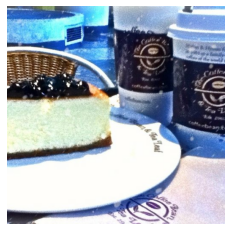

In [18]:
i= train_data.take(1)
for image, label in i:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)
  plt.imshow(image/255)
  plt.axis(False)
  plt.savefig('plot.jpg')

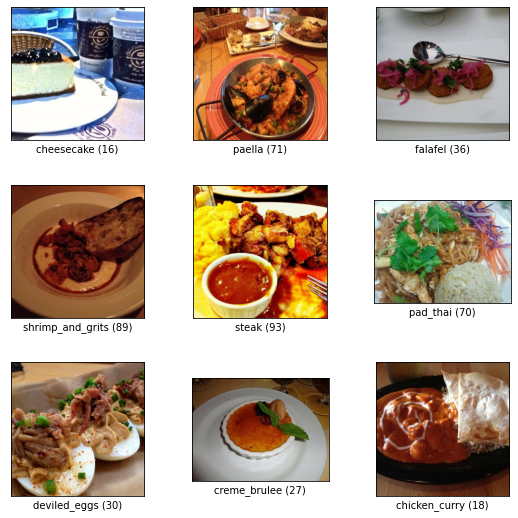

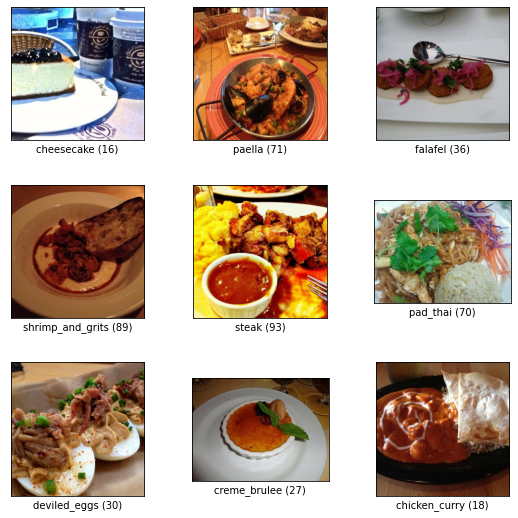

In [19]:
tfds.show_examples(train_data, ds_info)

In [20]:

  # Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
  # Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

  # Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
  # Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

model 1

In [ ]:
# Create base model
with strategy.scope():
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

    # Create Functional model 
  inputs = layers.Input(shape=input_shape, name="input_layer")
    # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  #x = preprocessing.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class 
    # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
  model = tf.keras.Model(inputs, outputs)

    # Compile the model
  model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
path = 'saved_model/'

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                        epochs=11,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.10 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", 
                                                                                                "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                    model_checkpoint])

In [ ]:
model.save("my_model.h5")
model.save(path, save_format='tf')

In [ ]:
model.evaluate(test_data)

model 2

In [ ]:
with strategy.scope():
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.EfficientNetB4(include_top=False)
    base_model.trainable = False # freeze base model layers

      # Create Functional model 
    inputs = layers.Input(shape=input_shape, name="input_layer")
      # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
    #x = preprocessing.Rescaling(1./255)(x)
    x = base_model(inputs, training=False) # set base_model to inference mode only
    x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = layers.Dense(len(class_names))(x) # want one output neuron per class 
      # Separate activation of output layer so we can output float32 activations
    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
    model2 = tf.keras.Model(inputs, outputs)

      # Compile the model
    model2.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
path = 'saved_model2/'

In [ ]:
history_101_food_classes_feature_extract2 = model2.fit(train_data, 
                                                        epochs=12,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.10 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", 
                                                                                                "efficientnetb4_101_classes_all_data_feature_extract"),
                                                                    model_checkpoint])

In [ ]:
model2.evaluate(test_data)

In [ ]:
model2.save("my_model2.h5")
model2.save(path, save_format='tf')

model 3

In [ ]:
# Create base model
with strategy.scope():
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.EfficientNetB7(include_top=False)
    base_model.trainable = False # freeze base model layers

      # Create Functional model 
    inputs = layers.Input(shape=input_shape, name="input_layer")
      # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
    #x = preprocessing.Rescaling(1./255)(x)
    x = base_model(inputs, training=False) # set base_model to inference mode only
    x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = layers.Dense(len(class_names))(x) # want one output neuron per class 
      # Separate activation of output layer so we can output float32 activations
    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
    model3 = tf.keras.Model(inputs, outputs)

      # Compile the model
    model3.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
history_101_food_classes_feature_extract3 = model3.fit(train_data, 
                                                        epochs=12,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.10 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", 
                                                                                                "efficientnetb7_101_classes_all_data_feature_extract"),
                                                                    model_checkpoint])

In [ ]:
model3.evaluate(test_data)

In [25]:
t1=b0.evaluate(test_data)
t2=b4.evaluate(test_data)
t3=b7.evaluate(test_data)

790/790 [==============================] - 623s 779ms/step - loss: 1.1873 - accuracy: 0.6885


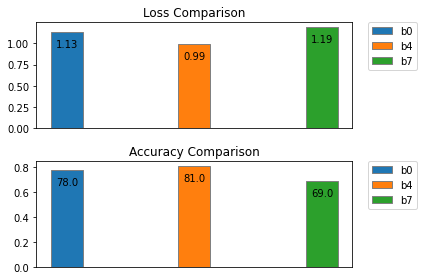

<Figure size 432x288 with 0 Axes>

In [47]:
x=([5,10,15])
barWidth = 0.25
br1 = np.arange(3) 
a1 = plt.subplot2grid((4,4),(0,0),colspan = 4,rowspan=2)
a2 = plt.subplot2grid((4,4),(2,0), rowspan = 2,colspan=4)
a1.bar( br1[0],t1[0], label = "b0",width = barWidth, edgecolor ='grey')
a1.bar( br1[1],t2[0], label = "b4",width = barWidth, edgecolor ='grey')
a1.bar( br1[2],t3[0], label = "b7",width = barWidth, edgecolor ='grey')
a1.axes.get_xaxis().set_visible(False)
for p in a1.patches:
    a1.annotate(format(round(p.get_height(),2)),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, -12),
                   textcoords='offset points')
a1.set_title("Loss Comparison")

a1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
a2.bar( br1[0],t1[1], label = "b0",width = barWidth, edgecolor ='grey')
a2.bar( br1[1],t2[1], label = "b4",width = barWidth, edgecolor ='grey')
a2.bar( br1[2],t3[1], label = "b7",width = barWidth, edgecolor ='grey')
a2.axes.get_xaxis().set_visible(False)
for p in a2.patches:
    a2.annotate(format(round(p.get_height(),2)*100),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, -12),
                   textcoords='offset points')
 
a2.set_title("Accuracy Comparison")
a2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show() 
plt.savefig('compare.jpg')

<HR>

In [22]:
!mkdir download_model
!unzip '/content/drive/MyDrive/Model/saved_model.zip' -d download_model
!mkdir download_model2
!unzip '/content/drive/MyDrive/Model/saved_model2.zip' -d download_model2
!mkdir download_model3
!unzip '/content/drive/MyDrive/Model/saved_model3.zip' -d download_model3

Archive:  /content/drive/MyDrive/Model/saved_model.zip
   creating: download_model/saved_model/
  inflating: download_model/saved_model/saved_model.pb  
   creating: download_model/saved_model/variables/
  inflating: download_model/saved_model/variables/variables.data-00000-of-00001  
  inflating: download_model/saved_model/variables/variables.index  
Archive:  /content/drive/MyDrive/Model/saved_model2.zip
   creating: download_model2/saved_model2/
  inflating: download_model2/saved_model2/saved_model.pb  
   creating: download_model2/saved_model2/variables/
  inflating: download_model2/saved_model2/variables/variables.data-00000-of-00001  
  inflating: download_model2/saved_model2/variables/variables.index  
Archive:  /content/drive/MyDrive/Model/saved_model3.zip
   creating: download_model3/saved_model3/
  inflating: download_model3/saved_model3/saved_model.pb  
   creating: download_model3/saved_model3/variables/
  inflating: download_model3/saved_model3/variables/variables.data-000

In [23]:
b0 = tf.keras.models.load_model("/content/download_model/saved_model")
b4 = tf.keras.models.load_model("/content/download_model2/saved_model2")
b7 = tf.keras.models.load_model("/content/download_model3/saved_model3")

In [ ]:
class_names=load_class()
def classify_b0(img,img_shape=224):
   #img = tf.image.decode_jpeg(img)
   # Resize the image
   img=img/255
   img = tf.image.resize(img,size=[img_shape,img_shape])
   newimg = np.asarray(img)
   pixels = newimg.astype('float32')
   pixels = np.expand_dims(pixels, axis=0)
   t=tf.convert_to_tensor(pixels,dtype=tf.float32)
   prediction = b0.predict(t).flatten()
   return {labels[i]: float(prediction[i]) for i in range(101)}
def classify_b4(img,img_shape=224):
   #img = tf.image.decode_jpeg(img)
   # Resize the image
   img=img/255
   img = tf.image.resize(img,size=[img_shape,img_shape])
   newimg = np.asarray(img)
   pixels = newimg.astype('float32')
   pixels = np.expand_dims(pixels, axis=0)
   t=tf.convert_to_tensor(pixels,dtype=tf.float32)
   prediction = b4.predict(t).flatten()
   return {labels[i]: float(prediction[i]) for i in range(101)}
def classify_b7(img,img_shape=224):
   #img = tf.image.decode_jpeg(img)
   # Resize the image
   img=img/255
   img = tf.image.resize(img,size=[img_shape,img_shape])
   newimg = np.asarray(img)
   pixels = newimg.astype('float32')
   pixels = np.expand_dims(pixels, axis=0)
   t=tf.convert_to_tensor(pixels,dtype=tf.float32)
   prediction = b7.predict(t).flatten()
   return {labels[i]: float(prediction[i]) for i in range(101)}
#images


labels=class_names
image = gr.inputs.Image()
label = gr.outputs.Label(num_top_classes=3)
gr.Interface([classify_b0,classify_b4,classify_b7],image,label,title="Efficient B0 vs Efficient B4 vs Efficient B7").launch(debug=True);

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou